# CONCATENATION DES MODELES IMG / TEXTE

### Ce notebook a pour objectif de concaténer les sorties des meilleurs modèles texte / image en entraînant quelques couches de réseaux de neurones denses supplémentaires, afin de tirer le meilleur parti des 2 modèles

##### Import des librairies

In [19]:
import joblib
import pandas as pd
import seaborn as sns
import numpy as np
import os
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms, models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from save.vit_pipeline import ViTPipeline

##### Variables globales

In [2]:
DATA_DIR = "../data/processed/img_classified_by_prdtypecode"
CSV_FILE = "../data/csv_files/img-text-clean-data.csv"
SAVE_DIR = "save"
TEXT_MODEL_PATH = f"{SAVE_DIR}/finalized_model_text.sav"
IMG_MODEL_PATH = f"{SAVE_DIR}/vit_2024-09-28_epoch10of10.pth"
FINAL_IMG_MODEL_PATH = f"{SAVE_DIR}/finalized_model_img.pth"
MAX_SAMPLES_PER_CAT = 750
NUM_CLASSES = 27
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 5

##### Chargement du DataFrame

In [3]:
df = pd.read_csv(CSV_FILE)
display(df.head())
print(df.info())

,designation,description,productid,imageid,image name,image size in bits,prdtypecode,désignation textuelle,catégorie niv 1,desi_desc_cleaned
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg,14010,10,Livres anciens / occasion,Littérature,olivia personalisiertes notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg,14854,2280,"journaux, revues, magazines anciens",Littérature,journal arts art marche salon art asiatique pa...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg,6898,50,Accessoires & produits dérivés gaming,Jeux Vidéos,stylet ergonomique bleu gamepad nintendo wii s...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg,14404,1280,Jeux & jouets pour enfants,Jeux de société & Jouets,peluche donald europe disneyland marionnette d...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg,20435,2705,Livres neufs,Littérature,guerre tuques luc ideacute grandeur veut organ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   designation            84916 non-null  object
 1   description            55116 non-null  object
 2   productid              84916 non-null  int64 
 3   imageid                84916 non-null  int64 
 4   image name             84916 non-null  object
 5   image size in bits     84916 non-null  int64 
 6   prdtypecode            84916 non-null  int64 
 7   désignation textuelle  84916 non-null  object
 8   catégorie niv 1        84916 non-null  object
 9   desi_desc_cleaned      84521 non-null  object
dtypes: int64(4), object(6)
memory usage: 6.5+ MB
None


##### Réduction du dataframe

In [4]:
# Suppression des NaN 'desi_desc_cleaned'
df = df.dropna(subset=['desi_desc_cleaned'])

# Sélection de 750 lignes par 'prdtypecode'
df = df.groupby('prdtypecode').apply(lambda x: x.sample(min(MAX_SAMPLES_PER_CAT, len(x)))).reset_index(drop = True)

# Affichage
print(df['prdtypecode'].value_counts())

prdtypecode
10      750
1920    750
2705    750
2585    750
2583    750
2582    750
2522    750
2462    750
2403    750
2280    750
2220    750
2060    750
1940    750
1560    750
40      750
1320    750
1302    750
1301    750
1300    750
1281    750
1280    750
1180    750
1160    750
1140    750
60      750
50      750
2905    750
Name: count, dtype: int64


/var/folders/gt/g8pv54y5059bybqc9m7nn9sh0000gn/T/ipykernel_42822/4105146924.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('prdtypecode').apply(lambda x: x.sample(min(MAX_SAMPLES_PER_CAT, len(x)))).reset_index(drop = True)


##### Chargement du modèle text (LogisticRegression) et tests

In [6]:
# Chargement du modèle Texte
text_model = joblib.load(TEXT_MODEL_PATH)

# Afficher le type du modèle
print("Type du modèle chargé :", type(text_model))

# Afficher les paramètres du modèle (si disponible)
if hasattr(text_model, 'get_params'):
    print("Paramètres du modèle :")
    print(text_model.get_params())

# Test du modèle : Sélection d'une ligne aléatoire du DataFrame
random_row = df.sample(1).iloc[0]

# Extraction des variables
text_description = random_row['desi_desc_cleaned']
prdtypecode = random_row['prdtypecode']
image_name = random_row['image name']
text_designation = random_row['désignation textuelle']

# Affichage des variables
print("Description du produit :", text_description)
print("prdtypecode :", prdtypecode)
print("désignation textuelle:", text_designation)
print("Image name :", image_name)

# Affichage de l'image
image_path = f"{DATA_DIR}/{prdtypecode}/{image_name}"
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print(f"L'image n'existe pas à l'emplacement {image_path}")

# Prédiction
prediction = text_model.predict([text_description])
print("Prédiction du modèle :", prediction)
print("désignation textuelle: ", (df.loc[df['prdtypecode'] == int(prediction), 'désignation textuelle']).iloc[0])
print("Type de la sortie (prédiction) :", type(prediction))
print("Dimension de la sortie (prédiction) :", prediction.shape if hasattr(prediction, 'shape') else len(prediction))

# Affichage des probabilités
if hasattr(text_model, 'predict_proba'):
    probabilities = text_model.predict_proba([text_description])
    print("Noms des classes :", text_model.classes_)
    print("Prédiction du modèle (probabilités) :", probabilities)
    print("Taille du vecteur de probabilités :", len(probabilities[0]))
    print("Type de la sortie (probabilités) :", type(probabilities))
    print("Dimension de la sortie (probabilités) :", probabilities.shape)
else:
    print("Le modèle ne supporte pas la prédiction des probabilités.")

Type du modèle chargé : <class 'sklearn.pipeline.Pipeline'>
Paramètres du modèle :
{'memory': None, 'steps': [('cv', CountVectorizer()), ('model', LogisticRegression(C=1, max_iter=1000))], 'verbose': False, 'cv': CountVectorizer(), 'model': LogisticRegression(C=1, max_iter=1000), 'cv__analyzer': 'word', 'cv__binary': False, 'cv__decode_error': 'strict', 'cv__dtype': <class 'numpy.int64'>, 'cv__encoding': 'utf-8', 'cv__input': 'content', 'cv__lowercase': True, 'cv__max_df': 1.0, 'cv__max_features': None, 'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'cv__preprocessor': None, 'cv__stop_words': None, 'cv__strip_accents': None, 'cv__token_pattern': '(?u)\\b\\w\\w+\\b', 'cv__tokenizer': None, 'cv__vocabulary': None, 'model__C': 1, 'model__class_weight': None, 'model__dual': False, 'model__fit_intercept': True, 'model__intercept_scaling': 1, 'model__l1_ratio': None, 'model__max_iter': 1000, 'model__multi_class': 'deprecated', 'model__n_jobs': None, 'model__penalty': 'l2', 'model__random_state'

### Chargement du modèle image sans pipeline (Vision Transformer)
##### /!\ Ne pas exécuter si vous disposez déjà du model version pipeline et de ses dépendances: 
- fichier '.pth'
- vit_pipeline.py

In [7]:
# Chargement du modèle utilisé
model_img = models.vit_l_16(pretrained = False)

# Nouvelle tête de classification aux dimensions appropriées
num_classes = 27
in_features = model_img.heads.head.in_features
print("num_classes: ", num_classes)
print("in_features: ", in_features)
model_img.heads.head = torch.nn.Linear(in_features, num_classes)

# Chargement du checkpoint
checkpoint = torch.load(IMG_MODEL_PATH)
print("Keys du modèle chargé :", checkpoint.keys())

# Chargement de l'état du modèle à partir du checkpoint
model_img.load_state_dict(checkpoint['model_state_dict'])

# Chargement des poids de l'ancienne tête de classification
old_head_weights = checkpoint['model_state_dict']['heads.head.weight']
old_head_bias = checkpoint['model_state_dict']['heads.head.bias']

# Affectation des poids / biais à la nouvelle tête de classification
with torch.no_grad():
    model_img.heads.head.weight[:old_head_weights.size(0), :] = old_head_weights
    model_img.heads.head.bias[:old_head_bias.size(0)] = old_head_bias

# Évaluer le modèle
model_img.eval()

# Affichage des caractéristiques du modèle
print("Caractéristiques du modèle :")
print(model_img)


/opt/anaconda3/envs/mle-rakuten-p3_10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mle-rakuten-p3_10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


num_classes:  27
in_features:  1024


/var/folders/gt/g8pv54y5059bybqc9m7nn9sh0000gn/T/ipykernel_42822/3571696162.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(IMG_MODEL_PATH)


FileNotFoundError: [Errno 2] No such file or directory: 'save/vit_2024-09-28_epoch10of10.pth'

##### Test du modèle image
##### /!\ Ne pas exécuter si vous disposez déjà du model et de ses dépendances: 
- fichier '.pth'
- vit_pipeline.py

In [21]:
# Transformations préalables
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test du modèle : Sélection d'une ligne aléatoire du DataFrame
random_row = df.sample(1).iloc[0]

# Extraction des variables
text_description = random_row['desi_desc_cleaned']
prdtypecode = random_row['prdtypecode']
image_name = random_row['image name']
text_designation = random_row['désignation textuelle']

# Affichage des variables
print("Description du produit :", text_description)
print("prdtypecode :", prdtypecode)
print("désignation textuelle:", text_designation)
print("Image name :", image_name)

# Chargement et affichage de l'image
image_path = f"{DATA_DIR}/{prdtypecode}/{image_name}"
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)
else:
    print(f"L'image n'existe pas à l'emplacement {image_path}")

# Prédiction
with torch.no_grad():
    output = model_img(img)
    probabilities = F.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, 1)
    print("Type de la sortie du modèle :", type(output))
    print("Dimension de la sortie du modèle :", output.size())
prdtypecode_list = ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', 
                    '1302', '1320', '1560', '1920', '1940', '2060', '2220', 
                    '2280', '2403', '2462', '2522', '2582', '2583', '2585', 
                    '2705', '2905', '40', '50', '60']
predicted_class = prdtypecode_list[predicted_class.item()]
print("Classe prédite :", predicted_class)
print("désignation textuelle: ", (df.loc[df['prdtypecode'] == int(predicted_class), 'désignation textuelle']).iloc[0])
print("Vecteur de probabilités :", probabilities)
print("Taille du vecteur de probabilités :", probabilities.size())




Description du produit : sins solar empire rebellion ultimate edition jeu téléchargement compte steam connexion internet nécessaires activer télécharger utiliser produit ultimate edition articles inclus package sins solar empire rebellion sins solar empire rebellion original soundtrack sins solar empire rebellion forbidden worlds sins solar empire rebellion stellar phenomena propos jeu nouvel épisode primé personnes espéraient voir diplomatie mettre terme guerre différences dopinion marche lépuisement factions régnantes conduit fragmentation groupes concernés membres loyalistes coalition marchande durgence adopté politique disolation concentrant lamélioration défenses surmonter guerre rebelles préféré vision purement militaire arrivés conclusion dapporter paix décraser sopposent particulier xenos guerre provoqué schisme sein unité advent fois histoire loyalistes continuent politique revancharde contre marchands tentent dassimiler groupes placer linfluence unité membres advent soupçonne

AttributeError: 'JpegImageFile' object has no attribute 'shape'

##### Création d'un pipeline final pour le modèle image et test
##### /!\ Ne pas exécuter si vous disposez déjà du model et de ses dépendances: 
- fichier '.pth'
- vit_pipeline.py

In [ ]:
# Transformations à appliquer
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Liste des vraies valeurs prdtypecode
prdtypecode_list = ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', 
                    '1302', '1320', '1560', '1920', '1940', '2060', '2220', 
                    '2280', '2403', '2462', '2522', '2582', '2583', '2585', 
                    '2705', '2905', '40', '50', '60']

# Classe de l'objet final (transfo + model)
class ViTPipeline:
    def __init__(self, model, transform, prdtypecode_list):
        self.model = model
        self.transform = transform
        self.prdtypecode_list = prdtypecode_list
        self.model.eval()

    def predict(self, image_path):
        # Ouverture de l'image
        img = Image.open(image_path)
        
        # Transformation de l'image
        img_transformed = self.transform(img).unsqueeze(0)
        
        # Prédiction du modèle
        with torch.no_grad():
            output = self.model(img_transformed)
            probabilities = F.softmax(output, dim = 1)
            _, predicted_class = torch.max(probabilities, 1)
        
        # Correspondance label -> prdtypecode
        predicted_prdtypecode = self.get_prdtypecode(predicted_class.item())

        return predicted_prdtypecode, probabilities.squeeze()

    def get_prdtypecode(self, label):
        """Permet de faire la correspondance entre le label retourné par le modèle (0 à 26) et la vraie valeur de prdtypecode"""
        return self.prdtypecode_list[label]

# Création de l'objet final
vit_pipeline = ViTPipeline(model_img, transform, prdtypecode_list)

# Sauvegarde sous forme de fichier
save_path = os.path.join(SAVE_DIR, 'finalized_model_img.pth')
torch.save(vit_pipeline, save_path)
print(f"Pipeline ViT sauvegardé à : {save_path}")



In [7]:
# Transformations à appliquer
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Liste des vraies valeurs prdtypecode
prdtypecode_list = ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', 
                    '1302', '1320', '1560', '1920', '1940', '2060', '2220', 
                    '2280', '2403', '2462', '2522', '2582', '2583', '2585', 
                    '2705', '2905', '40', '50', '60']

# Liste qui organise les classes comme pour le modèle image, par ordre croissant, afin que les tenseurs de probas soient organisés de la mm manière
prdtypecode_sorted = ['10', '40', '50', '60', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', 
                      '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', 
                      '2705', '2905']

# Créer une instance de ViTPipeline
vit_pipeline = ViTPipeline(model_img, transform, prdtypecode_list, prdtypecode_sorted)

# Sauvegarde sous forme de fichier
save_path = os.path.join(SAVE_DIR, 'finalized_model_img.pth')
torch.save(vit_pipeline, save_path)
print(f"Pipeline ViT sauvegardé à : {save_path}")

Pipeline ViT sauvegardé à : save\finalized_model_img.pth


### Chargement du modèle image avec pipeline
##### A exécuter si vous disposez du fichier 'finalized_model_img.pth' et sa dépendance 'vit_pipeline.py' (voir 'README_vit_pipeline.txt')

In [26]:
img_model = torch.load(FINAL_IMG_MODEL_PATH)

/var/folders/gt/g8pv54y5059bybqc9m7nn9sh0000gn/T/ipykernel_42822/2427087559.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_model = torch.load(FINAL_IMG_MODEL_PATH)


Description du produit : lot playmobil pirates
prdtypecode réel : 2462
désignation textuelle: consoles, jeux et équipement occasion
Image name : image_1218706325_product_3516388756.jpg


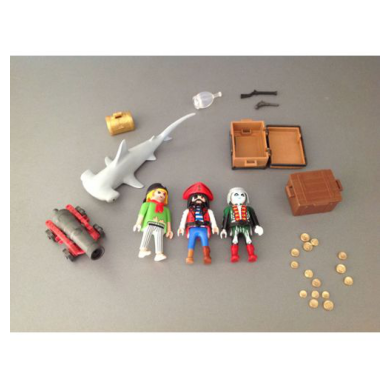

prdtypecode prédit : 1140
désignation textuelle correspondante: Figurines
Type de la sortie de predicted_prdtypecode : <class 'str'>
Vecteur de probabilités : tensor([2.7283e-04, 9.6488e-03, 1.2455e-02, 2.9043e-03, 3.4590e-01, 5.4891e-04,
        1.7490e-01, 1.0614e-01, 9.5848e-02, 4.2745e-02, 3.4993e-02, 5.9649e-03,
        2.7971e-02, 1.4764e-03, 2.1239e-04, 1.7220e-03, 3.8268e-02, 1.7551e-03,
        1.0528e-03, 1.7083e-03, 8.5166e-02, 7.9654e-04, 7.3190e-04, 1.9006e-04,
        3.2968e-03, 2.4477e-04, 3.0833e-03])
Type de la sortie de probabilities : <class 'torch.Tensor'>
Taille du vecteur de probabilités : torch.Size([27])
Le modèle ne contient pas d'attribut 'classes_' pour les noms des classes.


In [27]:
# Test du model pipeline img : Sélection d'une ligne aléatoire du DataFrame
random_row = df.sample(1).iloc[0]

# Extraction des variables
text_description = random_row['desi_desc_cleaned']
prdtypecode = random_row['prdtypecode']
image_name = random_row['image name']
text_designation = random_row['désignation textuelle']

# Affichage des variables
print("Description du produit :", text_description)
print("prdtypecode réel :", prdtypecode)
print("désignation textuelle:", text_designation)
print("Image name :", image_name)

# Chargement et affichage de l'image
image_path = f"{DATA_DIR}/{prdtypecode}/{image_name}"
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print(f"L'image n'existe pas : {image_path}")

# Prédiction avec le modèle d'image (pipeline)
predicted_prdtypecode, probabilities = img_model.predict(image_path)

# Affichage des résultats
print("prdtypecode prédit :", predicted_prdtypecode)
print("désignation textuelle correspondante:",
      df.loc[df['prdtypecode'] == int(predicted_prdtypecode), 'désignation textuelle'].iloc[0])

# Informations sur la prédiction
print("Type de la sortie de predicted_prdtypecode :", type(predicted_prdtypecode))
print("Vecteur de probabilités :", probabilities)
print("Type de la sortie de probabilities :", type(probabilities))
print("Taille du vecteur de probabilités :", probabilities.size())

# Affichage des noms des classes
if hasattr(img_model, 'classes_'):
    class_names = img_model.classes_  # Récupération des noms des classes
    print("Noms des classes :", class_names)

    # Affichage des probabilités avec les noms des classes
    for class_name, prob in zip(class_names, probabilities):
        print(f"Probabilité pour la classe '{class_name}': {prob:.4f}")
else:
    print("Le modèle ne contient pas d'attribut 'classes_' pour les noms des classes.")

##### DataLoaders

Le code ci-dessous permet d'effectuer la conversion entre la liste de 27 prdtypecode en une liste de valeurs allant de 0 à 26 qui serviront pour la labellisation des cibles du modèle

In [55]:
# Liste des prdtypecode
prdtypecode_list = ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', 
                    '1302', '1320', '1560', '1920', '1940', '2060', '2220', 
                    '2280', '2403', '2462', '2522', '2582', '2583', '2585', 
                    '2705', '2905', '40', '50', '60']

# Tri de la liste par ordre ascendant
sorted_prdtypecode_list = sorted(prdtypecode_list, key = int)

# Dict avec "key":"value" = "prdtypecode":"index" (ou "index" est l'index du "prdtypecode dans la liste triée")
prdtypecode_dict = {code: index for index, code in enumerate(sorted_prdtypecode_list)}

# Affichage
print(prdtypecode_dict)

{'10': 0, '40': 1, '50': 2, '60': 3, '1140': 4, '1160': 5, '1180': 6, '1280': 7, '1281': 8, '1300': 9, '1301': 10, '1302': 11, '1320': 12, '1560': 13, '1920': 14, '1940': 15, '2060': 16, '2220': 17, '2280': 18, '2403': 19, '2462': 20, '2522': 21, '2582': 22, '2583': 23, '2585': 24, '2705': 25, '2905': 26}


La classe ci-dessous récupère les sorties des modèles texte et image, ainsi que les labels

In [29]:
class EcommerceDataset(Dataset):
    '''
    - desc : cette classe combine les model text, img, effectue une prediction pour chaque et retourne les features
    - params :
      -> df : données des produits
      -> text_model : modèle texte (chargé)
      -> img_model : modèle image (chargé)
      -> img_dir : path racine du dossier image
    - returns :
      -> text_features : sortie du modèle text
      -> img_features : sortie du modèle img
      -> label : label correspondant
    '''
    def __init__(self, df, text_model, img_model, img_dir):
        self.df = df
        self.text_model = text_model
        self.img_model = img_model
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extraction text / img
        text_description = self.df.iloc[idx]['desi_desc_cleaned']
        prdtypecode = self.df.iloc[idx]['prdtypecode']
        image_name = self.df.iloc[idx]['image name']

        # path img
        image_path = os.path.join(self.img_dir, str(prdtypecode), image_name)
        
        # Chargement img
        img = Image.open(image_path)
        
        # Model prediction text - vecteur de probas
        text_features = self.text_model.predict_proba([text_description])[0]
        #print("type(text_features) : ", type(text_features))
        #print("len(text_features) : ", len(text_features))
        # Conversion en tensor si nécessaire
        if isinstance(text_features, np.ndarray):
            text_features = torch.tensor(text_features, dtype = torch.float32)
        #print("type(text_features) after tensor conv : ", type(text_features))
        #print("len(text_features) after tensor conv : ", len(text_features))
          
         # Prédictions du modèle image - vecteur de probas
        _, img_features = img_model.predict(image_path)
        #print("type(img_features) : ", type(img_features))
        #print("len(img_features) : ", len(img_features))
        # Conversion en tensor si nécessaire
        if isinstance(img_features, np.ndarray):
            img_features = torch.tensor(img_features, dtype = torch.float32)
        #print("type(img_features) after tensor conv : ", type(img_features))
        #print("len(img_features) after tensor conv : ", len(img_features))

        label = prdtypecode_dict[str(prdtypecode)]
        #print(f" In EcommerceDataset : Label: {label}, Type: {type(label)}, Size: {label.shape if hasattr(label, 'shape') else 'N/A'}")

        return text_features, img_features, label

In [30]:
# train test split
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Initialisation des datasets
train_dataset = EcommerceDataset(train_df, text_model, img_model, DATA_DIR)
val_dataset = EcommerceDataset(val_df, text_model, img_model, DATA_DIR)

# Loaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

Le code ci-dessous permet de générer quelques exemples de produits issus du dataset et des sorties des modèles texte / image

Example 1:
Text features (from text model):
Label: tensor([12, 26, 23, 13, 24, 18,  8, 15, 22, 24,  7, 17, 26, 21,  9, 13, 12, 12,
        14,  2,  6, 16,  3,  1, 22,  9, 16, 18, 21, 26,  4, 10])



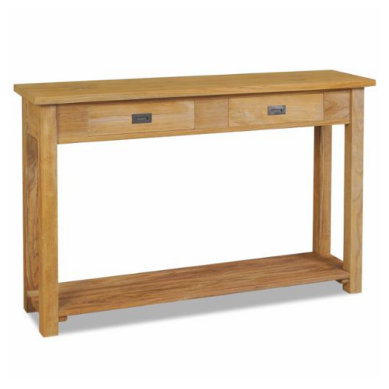

Image features (from image model):
--------------------------------------------------
Example 2:
Text features (from text model):
Label: tensor([20,  7,  1,  2,  7, 12,  5,  0,  4, 14,  2, 22, 12, 20,  9, 22,  9,  1,
        10,  4,  9, 19,  8,  0, 23, 13,  5, 19,  5, 10,  5, 18])



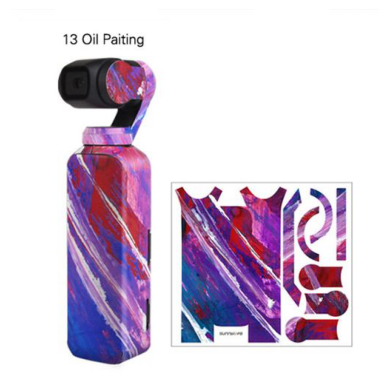

Image features (from image model):
--------------------------------------------------
Example 3:
Text features (from text model):
Label: tensor([23, 15, 17, 11, 17, 25, 14, 26,  5, 11,  8,  4, 21, 23, 20, 16,  2, 21,
         8, 26, 12, 23,  3, 20, 21,  6, 21, 10, 18,  2, 10, 11])



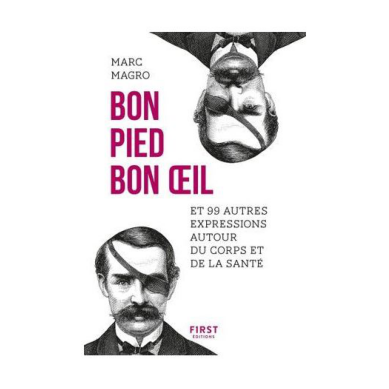

Image features (from image model):
--------------------------------------------------
Example 4:
Text features (from text model):
Label: tensor([14, 18,  6,  1, 11,  6, 25, 12, 18, 24,  0, 16,  3, 15, 12, 11,  7,  4,
         6,  4, 16, 21, 26, 21, 12, 22, 19,  9, 14, 20,  1, 16])



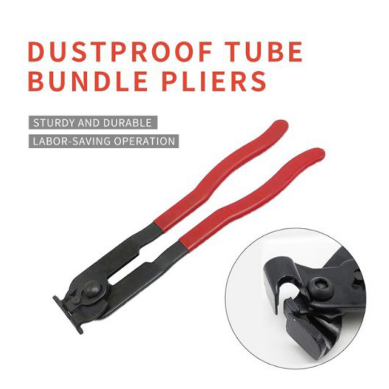

Image features (from image model):
--------------------------------------------------
Example 5:
Text features (from text model):
Label: tensor([18, 24,  6, 14, 11, 10, 15, 17,  0, 15, 15,  9,  8, 19, 24,  4,  3, 16,
         2,  0,  0, 26, 16, 23, 13, 11, 18, 11,  2, 23, 16, 16])



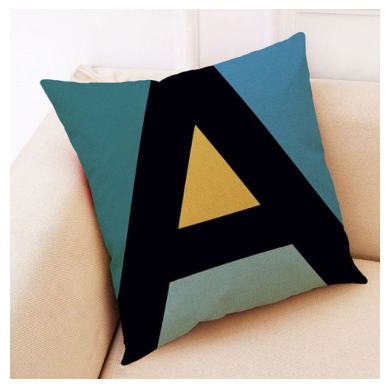

Image features (from image model):
--------------------------------------------------


In [38]:
def show_examples(loader, num_examples = 5):
    '''
    - desc : Affiche quelques examples d'entrées img / text du loader et des sorties associées
    - params:
      -> loader : un Dataloader (train ou val)
      -> num_examples : nombre d'exemples à afficher
    '''
    
    # Récupération de quelques batchs dans le loader
    data_iter = iter(loader)
    
    for i in range(num_examples):
        text_features, img_features, label = next(data_iter)
        
        # Affichage des informations textuelles et du label
        print(f"Example {i+1}:")
        print("Text features (from text model):")
        #print(text_features)
        print(f"Label: {label}\n")
        
        # Affichage de l'image associée
        image_name = train_df.iloc[i]['image name']
        prdtypecode = train_df.iloc[i]['prdtypecode']
        image_path = os.path.join(DATA_DIR, str(prdtypecode), image_name)   
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Affichage des caractéristiques d'image obtenues par le modèle d'image
        print("Image features (from image model):")
        #print(img_features)  # Affiche les features de l'image
        print('-' * 50)

show_examples(train_loader, num_examples = 5)

##### Modèle de classification combiné

La classe ci-dessous prend en entrée les sorties des modèles texte et image et crée quelques couches de classification finale

In [37]:
class CombinedModel(nn.Module):
    '''
    - desc : combine les entrées img et text et construit les couches de classification finale
    - params:
      -> text_input_size : taille du vecteur texte
      -> image_input_size : taille du vecteur image
      -> num_classes : nombre de classes en sortie de la couche de classification
    '''
    def __init__(self, text_input_size, image_input_size, num_classes):
        super(CombinedModel, self).__init__()
        # Deux couches fully connected (dense)
        self.fc1 = nn.Linear(text_input_size + image_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, combined_features):
        # Concat des sorties des 2 model
        x = self.relu(self.fc1(combined_features))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x

##### Fonction d'entraînement

In [18]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 10, patience = 5, save_path = "save"):

    # plateau sur le learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3, verbose = True)

    # early stopping
    early_stopping_patience = patience
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # metrics list
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):

        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for text_features, img_features, labels in tqdm(train_loader, desc = 'Training', unit = 'batch'):
            optimizer.zero_grad()

            # combinaison des features text / img
            combined_features = torch.cat((text_features, img_features), dim = 1)

            # Prédiction et calcul de la loss
            outputs = model(combined_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calcul de la perte et de la précision
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct.double() / total

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.item())

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for text_features, img_features, labels in tqdm(val_loader, desc = 'Validation', unit = 'batch'):
                
                # combinaison des features text / img
                combined_features = torch.cat((text_features, img_features), dim = 1)

                outputs = model(combined_features)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

        val_loss = running_loss / total
        val_acc = correct.double() / total

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        # Affichage des métriques
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Affichage du learning rate
        lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {lr}")

        # Sauvegarde du meilleur modèle
        os.makedirs(save_path, exist_ok = True)
        current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        save_model_path = os.path.join(save_path, f'concatmodel_{current_time}_epoch{epoch+1}of{EPOCHS}.pth')
        torch.save(model.state_dict(), save_model_path)
        print("Model saved at: ", save_model_path)
        print('-' * 20)

        # Scheduler et Early Stopping
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered")
                break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

### Affichage des métriques 

##### Loss and Accuracy

In [19]:
def plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    '''
    - desc : Affiche l'évolution de la loss et de l'accuracy du modèle en fonction des epoch
    - params:
      -> train_loss_history : historique de la loss sur le datset train
      -> val_loss_history : historique de la loss sur le dataset de validation
      -> train_acc_history : historique de l'accuravcy sur le dataset de train
      -> val_acc_history : historique de l'accuracy sur le dataset de validation
    '''
    plt.figure(figsize = (14, 6))

    # Affichage de la courbe de loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label = 'Train Loss')
    plt.plot(val_loss_history, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution during Training')
    plt.legend()
    plt.grid(True)

    # Affichage de la courbe d'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label = 'Train Accuracy')
    plt.plot(val_acc_history, label = 'Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Evolution during Training (model concat)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

##### Rapport de classification

In [20]:
def plot_classification_report(y_true, y_pred, df):
    '''
    - desc: Affiche le rapport de classification du modèle
    - params:
      -> y_true : vrais labels
      -> y_pred : labels prédits
      -> df : données des produits
    '''
    # Extraction des classes prdtypecode du DataFrame
    target_names = sorted(df['prdtypecode'].unique().astype(str))

    # Génération du rapport de classification
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict = True)

    # Transformation du rapport en DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Suppression de l'entrée 'support'
    if 'support' in report_df.columns:
        report_df = report_df.drop(columns=['support'])

    plt.figure(figsize = (10, 6))
    sns.heatmap(report_df, annot = True, cmap = 'Blues', fmt = ".2f")
    plt.title("Classification Report Heatmap (model concat)")
    plt.show()

##### Matrice de confusion

In [21]:
def plot_confusion_matrix(y_true, y_pred, df):
    '''
     - desc: Affiche la matrice de confusion du modèle
     - params:
      -> y_true : vrais labels
      -> y_pred : labels prédits
      -> df : données des produits
    '''

    # Extraction des classes prdtypecode du DataFrame
    target_names = sorted(df['prdtypecode'].unique().astype(str))

    # Génération de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # heatmap de la matrice de confusion
    plt.figure(figsize = (10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', xticklabels = target_names, yticklabels = target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (model concat)')
    plt.show()

### Lancement du training

In [25]:
# Initialisation du modèle
combined_model = CombinedModel(text_input_size = 27, image_input_size = 27, num_classes = NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr = LEARNING_RATE)

# Training
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    combined_model, criterion, optimizer, train_loader, val_loader, num_epochs = EPOCHS, patience = EARLY_STOPPING_PATIENCE, save_path = SAVE_DIR)

Epoch 1/20


Validation: 100%|██████████| 127/127 [2:38:28<00:00, 74.87s/batch]  


Train Loss: 1.1758, Train Acc: 0.7894
Val Loss: 0.2743, Val Acc: 0.9440
Current Learning Rate: 0.001
Model saved at:  save\concatmodel_2024-10-03_19-09-22_epoch1of20.pth
--------------------
Epoch 2/20


Validation: 100%|██████████| 127/127 [2:00:23<00:00, 56.88s/batch]


Train Loss: 0.3260, Train Acc: 0.9306
Val Loss: 0.2506, Val Acc: 0.9459
Current Learning Rate: 0.001
Model saved at:  save\concatmodel_2024-10-04_05-35-49_epoch2of20.pth
--------------------
Epoch 3/20


Validation: 100%|██████████| 127/127 [1:55:42<00:00, 54.66s/batch]


Train Loss: 0.2954, Train Acc: 0.9349
Val Loss: 0.2453, Val Acc: 0.9489
Current Learning Rate: 0.001
Model saved at:  save\concatmodel_2024-10-04_15-11-07_epoch3of20.pth
--------------------
Epoch 4/20


Training:   1%|          | 5/507 [04:33<7:38:07, 54.76s/batch]

##### Evaluation du modèle

In [45]:
# Prédictions
y_true = []
y_pred = []

combined_model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = combined_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Affichage des métriques
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
plot_classification_report(y_true, y_pred, df)
plot_confusion_matrix(y_true, y_pred, df)

NameError: name 'combined_model' is not defined

/var/folders/gt/g8pv54y5059bybqc9m7nn9sh0000gn/T/ipykernel_42822/3070504203.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_combined_checkpoint = torch.load('/User

Designation:, Queue Longoni Black Fox SS-Longoni
Description: nan


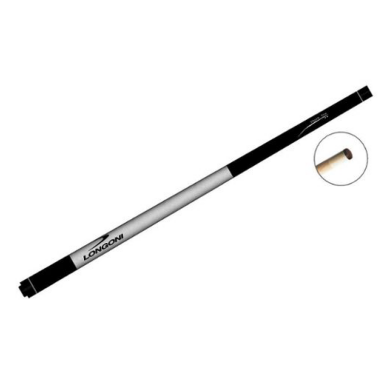

expected code: 1301
expected code label: Vêtements bébé et jeux pour la maison
Text prediction : [1301]
outputs : tensor([[ -4.1251,  -3.8750,  -1.9047, -11.4982,  -5.2858,  -7.1361,  -3.7779,
          -1.5680,  -3.0278, -11.5374,  12.1059,  -1.2652,  -3.5769,  -6.3322,
          -2.5284, -10.6189,  -3.2370,  -4.8189, -11.0813, -10.9351,  -7.0205,
          -6.9735,  -3.4690,  -5.8993,  -2.5330,  -9.4215, -12.0717]])
preds : tensor([10])
preds.item() : 10
labels.data : tensor([10])
predicted_class.item() : 10
Classe prédite : 1301
désignation textuelle:  Vêtements bébé et jeux pour la maison
--------------------
Designation:, Billard Brooklyn convertible en table à manger - Couleur wengé avec tapis vert-Ab_Direct_Import
Description: Cette table de billard convertible en table à manger apportera élégance et originalité à votre salon. Estampillée De Faugères  cette table convertible profite de l expérience de la marque afin de mettre à profit une qualité irréprochable. Ce modèle a été f

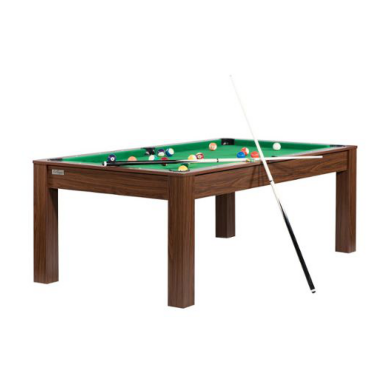

expected code: 1301
expected code label: Vêtements bébé et jeux pour la maison
Text prediction : [1301]
outputs : tensor([[ -4.1524,  -4.1486,  -2.1896, -13.5628,  -7.1031,  -7.3514,  -4.6142,
          -1.8853,  -3.3877, -14.0944,  16.0050,  -1.3344,  -4.7177,  -8.9242,
          -3.7211, -13.2222,  -4.6537,  -6.4358, -12.5907, -13.2303,  -7.6890,
         -10.6934,  -5.1080,  -7.2393,  -4.1927, -10.3700, -14.2321]])
preds : tensor([10])
preds.item() : 10
labels.data : tensor([10])
predicted_class.item() : 10
Classe prédite : 1301
désignation textuelle:  Vêtements bébé et jeux pour la maison
--------------------
Designation:, Living Stickers Muraux Horloge Murale Chambre Bureau Chambre Décoration E
Description: stickers muraux salon Horloge murale chambre bureau décoration Catégories de produits: meubles muraux stickers muraux Matériel: Acrylique Style: Classification moderne: Pour mur meubles autocollants Motif: Stickers muraux Horloge Thème: Stickers muraux horloge Scénarios: mur Fo

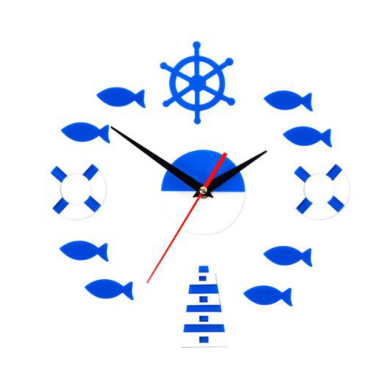

expected code: 2060
expected code label: Objets décoration maison
Text prediction : [2060]
outputs : tensor([[ -6.7403,  -5.3874,  -3.7119, -11.5492,  -2.3613,  -6.9328,  -4.1505,
          -3.5898,  -5.6018,  -6.8537,  -5.4797,  -0.8471,   0.4548,  -0.9071,
          -1.1219,  -7.3131,   6.4763,  -3.1487,  -5.4622,  -6.2145,  -9.9597,
          -1.9755,   0.1767,  -4.2245,  -2.2774,  -8.7940,  -7.5544]])
preds : tensor([16])
preds.item() : 16
labels.data : tensor([16])
predicted_class.item() : 16
Classe prédite : 2060
désignation textuelle:  Objets décoration maison
--------------------


In [97]:
model_combined_checkpoint = torch.load('/Users/ouissamgouni/Documents/it-workspace/bootcamp-mle-24/git/final/jul24_bds_rakuten/models/save/concatmodel_2024-10-07_08-52-25_epoch10of20.pth')
model_text = joblib.load('/Users/ouissamgouni/Documents/it-workspace/bootcamp-mle-24/git/final/jul24_bds_rakuten/models/save/finalized_model_text.sav')
model_img = torch.load('/Users/ouissamgouni/Documents/it-workspace/bootcamp-mle-24/git/final/jul24_bds_rakuten/models/save/finalized_model_img.pth')

model_c = CombinedModel(text_input_size = 27, image_input_size = 27, num_classes = NUM_CLASSES)
model_c.load_state_dict(model_combined_checkpoint)

model_c.eval()
prdtypecode_sorted = ['10', '40', '50', '60', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', 
                      '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', 
                      '2705', '2905']
with torch.no_grad():
    for i in range(3):
        demo_df= val_df.sample(n=1)
        designation = demo_df.iloc[0]['designation']
        print('Designation:,',designation)
        description = demo_df.iloc[0]['description']
        print('Description:',description)

        image_name = demo_df.iloc[0]['image name']
        prdtypecode = demo_df.iloc[0]['prdtypecode']
        image_path = os.path.join(DATA_DIR, str(prdtypecode), image_name)   
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        
        print('expected code:', prdtypecode)
        print('expected code label:',demo_df.iloc[0]['désignation textuelle'])


        text_prediction = model_text.predict([demo_df.iloc[0]['desi_desc_cleaned']])
        print("Text prediction :", text_prediction)

        demo_dataset = EcommerceDataset(demo_df, text_model, img_model, DATA_DIR)
        demo_loader = DataLoader(demo_dataset, batch_size = 1, shuffle = False)
    
        for text_features, img_features, labels in demo_loader:
            combined_features = torch.cat((text_features, img_features), dim = 1)
            outputs = model_c(combined_features)
            print("outputs :", outputs)
            #probabilities = F.softmax(outputs, dim=1)
            #print("probabilities :", probabilities)
            _, preds = torch.max(outputs, 1)
            print("preds :", preds)
            print("preds.item() :", preds.item())
            print("labels.data :", labels.data)
            # _, predicted_class = torch.max(probabilities, 1)
            print("predicted_class.item() :", preds.item())
            predicted_class = prdtypecode_sorted[preds.item()]
            print("Classe prédite :", predicted_class)
            print("désignation textuelle: ", (df.loc[df['prdtypecode'] == int(predicted_class), 'désignation textuelle']).iloc[0])
            print('-'*20)
            
